In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import cv2
import os
from google.colab.patches import cv2_imshow

In [ ]:
mainDIR = os.listdir('/content/drive/MyDrive/chest_xray (splited .7 .15 .15)')
print(mainDIR)

['train', 'val', 'test']


In [ ]:
train_folder= '/content/drive/MyDrive/chest_xray (splited .7 .15 .15)/train'
val_folder = '/content/drive/MyDrive/chest_xray (splited .7 .15 .15)/val'
test_folder = '/content/drive/MyDrive/chest_xray (splited .7 .15 .15)/test'

In [ ]:
# train 
train_n = train_folder+'/Normal/'
train_p = train_folder+'/Pneumonia/'
print(len(os.listdir(train_n)))

1108


In [ ]:
#get the minimum size
h_min = 100000
w_min = 100000
for img in os.listdir(train_n):
   x,y,z = (cv2.imread(train_n+img)).shape
   if x < h_min :
     h_min = x
   if y < w_min :
     w_min = y
print("H-min "+str(h_min))
print("W-min "+str(w_min))

496
984


# **close the gap**

In [ ]:
#data augmentation [close the gap] between Normal and pneumnia (we work only on train)
from keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
    rotation_range=10,
    shear_range = 20,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
)
#generate augmented data
normal_train_generator = datagen.flow_from_directory(train_folder,
                                                 target_size = (320,320),
                                                 batch_size = 32,
                                                 class_mode = 'binary',
                                                 classes=['Normal']  
                                                 )

Found 1108 images belonging to 1 classes.


In [ ]:
generated_x = np.concatenate([normal_train_generator.next()[0] for i in range(normal_train_generator.__len__())])
generated_y = np.concatenate([normal_train_generator.next()[1] for i in range(normal_train_generator.__len__())])

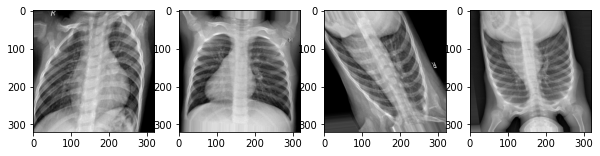

In [ ]:
#plot
fig = plt.figure(figsize=(10, 10))
columns = 4 
rows = 1
for i in range(1, columns*rows +1):
    fig.add_subplot(rows, columns, i)
    plt.imshow(generated_x[i+50]/255)
plt.show()

In [ ]:
print(generated_x[100].shape)

(320, 320, 3)


In [ ]:
for i in range(len(generated_x)):
# save images
  cv2.imwrite('/content/drive/MyDrive/Augmented Normal/'+str(i)+'.jpeg', generated_x[i])

In [ ]:
print(len(os.listdir('/content/drive/MyDrive/Augmented Normal/')))

1108


# **Adding Noise**

In [ ]:
def claheImage(img): #Nada
    # convert image to LAB color space
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    gray = cv2.convertScaleAbs(gray)
    # apply CLAHE to the L channel
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    cl = clahe.apply(gray)

    # convert the LAB image back to RGB color space
    final = cv2.cvtColor(cl, cv2.COLOR_GRAY2BGR)
    cl_img = np.float64(final)
    return cl_img

In [ ]:
#Gaussian noise
def add_gaussian_noise(image, mean):
    """
    Add Gaussian noise to an RGB image
    """
    x,y,z = image.shape
    if x < h_min :
      std_dev = 10
    else :
      std_dev = 50
    noisy_image = image.astype('float64') + np.random.normal(mean, std_dev, image.shape)
    noisy_image = np.uint8(np.clip(noisy_image, 0, 255))
    noisy_image  = cv2.cvtColor(noisy_image, cv2.COLOR_BGR2GRAY)
    noisy_image  = cv2.cvtColor(noisy_image, cv2.COLOR_GRAY2BGR)
    return noisy_image

In [ ]:
#Poisson noise
from scipy import ndimage
def add_poisson_noise(image):
    """
    Add Poisson noise to an RGB image
    """
    noisy_image = np.zeros_like(image)
    for i in range(3):
        noisy_image[:,:,i] = np.random.poisson(image[:,:,i].astype('float64'))
    noisy_image = np.uint8(np.clip(noisy_image, 0, 255))
    noisy_image  = cv2.cvtColor(noisy_image, cv2.COLOR_BGR2GRAY)
    noisy_image  = cv2.cvtColor(noisy_image, cv2.COLOR_GRAY2BGR)
    return noisy_image

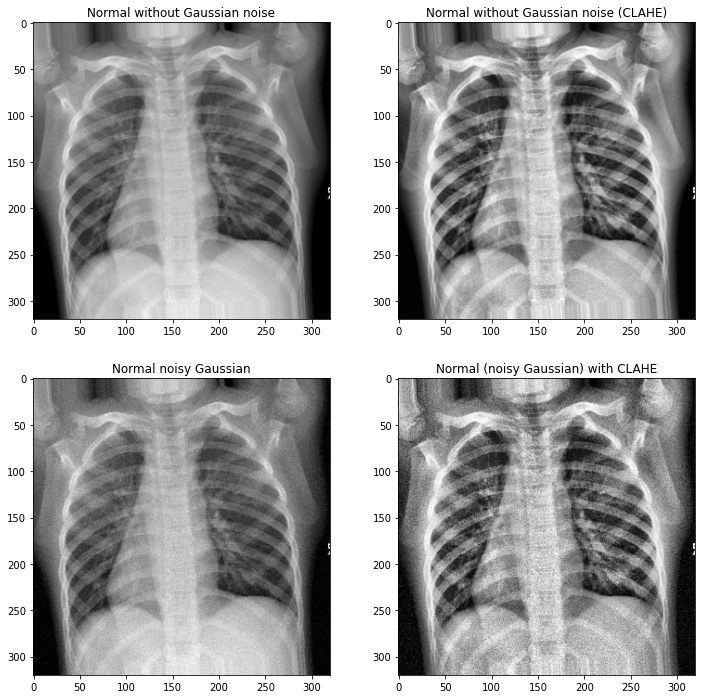

In [ ]:
# gaussian
img_n = cv2.imread('/content/drive/MyDrive/Augmented chest_xray (splited .7 .15 .15)/train/Normal/13.jpeg') #IM-0451-0001
res = add_gaussian_noise(img_n, mean=0)
#plot Pneumonia image with/without CLAHE
fig = plt.figure(figsize=(12, 12))
columns = 2 
rows = 2
fig.add_subplot(rows, columns, 1)
plt.title('Normal without Gaussian noise')
plt.imshow(img_n)

fig.add_subplot(rows, columns, 2)
plt.title('Normal without Gaussian noise (CLAHE)')
plt.imshow(claheImage(img_n)/255)

fig.add_subplot(rows, columns, 3)
plt.title('Normal noisy Gaussian')
plt.imshow(res)

fig.add_subplot(rows, columns, 4)
plt.title('Normal (noisy Gaussian) with CLAHE')
plt.imshow(claheImage(res)/255)
plt.show()

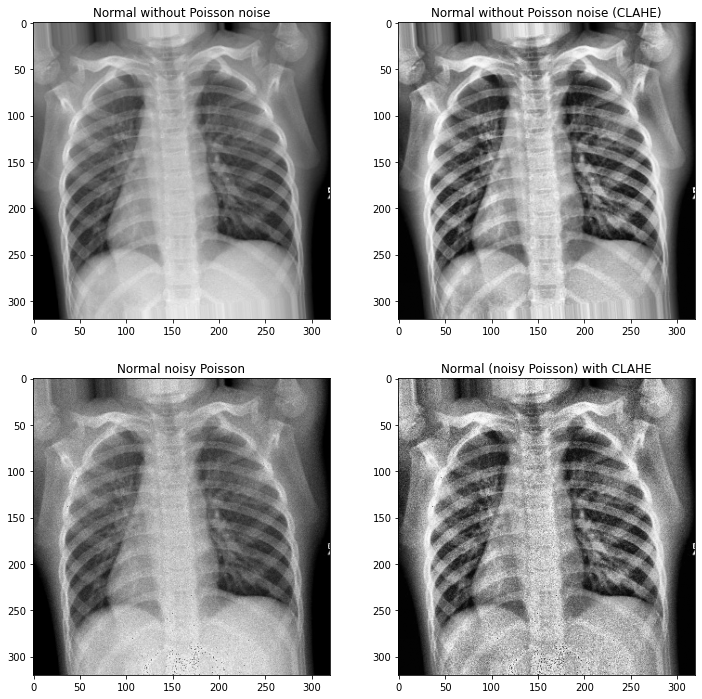

In [ ]:
#poisson
img_n = cv2.imread('/content/drive/MyDrive/Augmented chest_xray (splited .7 .15 .15)/train/Normal/13.jpeg') #IM-0451-0001
res = add_poisson_noise(img_n)
#plot Pneumonia image with/without CLAHE
fig = plt.figure(figsize=(12, 12))
columns = 2 
rows = 2
fig.add_subplot(rows, columns, 1)
plt.title('Normal without Poisson noise')
plt.imshow(img_n)

fig.add_subplot(rows, columns, 2)
plt.title('Normal without Poisson noise (CLAHE)')
plt.imshow(claheImage(img_n)/255)

fig.add_subplot(rows, columns, 3)
plt.title('Normal noisy Poisson')
plt.imshow(res)

fig.add_subplot(rows, columns, 4)
plt.title('Normal (noisy Poisson) with CLAHE')
plt.imshow(claheImage(res)/255)
plt.show()

In [ ]:
import random
# we work on augmented data
percent = 0.2
precent_gauss = 0.6
nbr_total_normal_train =len(os.listdir('/content/drive/MyDrive/Augmented chest_xray (splited .7 .15 .15)/train/Normal'))
nbr_total_pneumonia_train =len(os.listdir('/content/drive/MyDrive/Augmented chest_xray (splited .7 .15 .15)/train/Pneumonia'))
list_chosen_normal = random.sample(os.listdir('/content/drive/MyDrive/Augmented chest_xray (splited .7 .15 .15)/train/Normal'), k=int(nbr_total_normal_train*percent))
list_chosen_pneumonia = random.sample(os.listdir('/content/drive/MyDrive/Augmented chest_xray (splited .7 .15 .15)/train/Pneumonia'), k=int(nbr_total_pneumonia_train*percent))
print("Chosen Normal radios :"+str(len(list_chosen_normal)))
print("Chosen Normal radios :"+str(len(list_chosen_pneumonia)))

Chosen Normal radios :443
Chosen Normal radios :598


In [ ]:
print(len(np.unique(list_chosen_normal)))

443


In [ ]:
print(len(np.unique(list_chosen_pneumonia)))

598


In [ ]:
cpt_gn = 0
for i in range(int(nbr_total_normal_train*percent)):
    #Normal
    img_n = cv2.imread('/content/drive/MyDrive/Augmented chest_xray (splited .7 .15 .15)/train/Normal/'+list_chosen_normal[i])
    if cpt_gn <= int(nbr_total_normal_train * percent * precent_gauss) :
      img_res =  add_gaussian_noise(img_n, mean=0)
      value = cv2.imwrite('/content/drive/MyDrive/noise chest_xray/Normal/GAUS_'+list_chosen_normal[i], img_res)
      cpt_gn =cpt_gn +1
    else : 
      img_res =  add_poisson_noise(img_n)
      value = cv2.imwrite('/content/drive/MyDrive/noise chest_xray/Normal/POIS_'+list_chosen_normal[i], img_res)

In [ ]:
cpt_gp = 0
for i in range(int(nbr_total_pneumonia_train*percent)):
    img_p = cv2.imread('/content/drive/MyDrive/Augmented chest_xray (splited .7 .15 .15)/train/Pneumonia/'+list_chosen_pneumonia[i])
    if cpt_gp <= int(nbr_total_pneumonia_train * percent * precent_gauss) :
      img_res =  add_gaussian_noise(img_p, mean=0)
      cv2.imwrite('/content/drive/MyDrive/noise chest_xray/Pneumonia/GAUS_'+list_chosen_pneumonia[i], img_res)
      cpt_gp =cpt_gp+1
    else : 
      img_res =  add_poisson_noise(img_p)
      cv2.imwrite('/content/drive/MyDrive/noise chest_xray/Pneumonia/POIS_'+list_chosen_pneumonia[i], img_res)

In [ ]:
print(len(os.listdir('/content/drive/MyDrive/noise chest_xray/Normal')))

443


In [ ]:
print(len(os.listdir('/content/drive/MyDrive/noise chest_xray/Pneumonia')))

598
